# Additional Experimentation on Data Filtering

From previous iterations, we already applied some naive methods to reduce the number of data by 67.2643% based on simple rules:
- Remove null/nan data
- Text reviews that has less than 3 words
- Random sampling to balance the dataset based on an assumption that most of the positive feedbacks are similar 

Some of the known facts:
- We are trying to understand the experience that users have when using our application (that is the Spotify)
- We have some data, namely **user opinions**, **stars given**, the **number of people who agree** with the opinion, the **version of the application** used, and the **date** when the user gave the opinion.
- We're trying to improve the application, so use the latest version or the most used application instead of the older ones.

Now let's try to reduce the data by using the following methods:
- Application version might contains relevant information especially with the ratings and feedbacks. Lets **find the correlation between ratings and version**
- We're focusing on the latest version of the application, so **pick the latest version** and ignore the previous/older versions.

In [2]:
import re
import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haritsah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
df = pd.read_csv("../data/spotify_reviews_cleaned_filtered_balanced.csv")

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1105624 entries, 0 to 1105623
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   Unnamed: 0          1105624 non-null  int64 
 1   review_id           1105624 non-null  object
 2   author_name         1105624 non-null  object
 3   review_text         1105624 non-null  object
 4   review_rating       1105624 non-null  int64 
 5   review_likes        1105624 non-null  int64 
 6   author_app_version  1105624 non-null  object
 7   sentiment           1105624 non-null  object
 8   review_month        1105624 non-null  object
dtypes: int64(3), object(6)
memory usage: 75.9+ MB


## Preprocess Relevant Information

The app_version has 4 main parts, i.e. **8.8.76.98**, but we're focusing on the **{major}.{minor}.{patch}** and ignore the last one.

In [36]:
df[['major_version', 'minor_version', 'patch_version']] = df['author_app_version'].str.split('.', expand=True).iloc[:, :3].astype(int)

# Statistics

## Application Version w.r.t Review Ratings

### Major Application Version

Based on the results, we can see that the latest version is **Version 8**

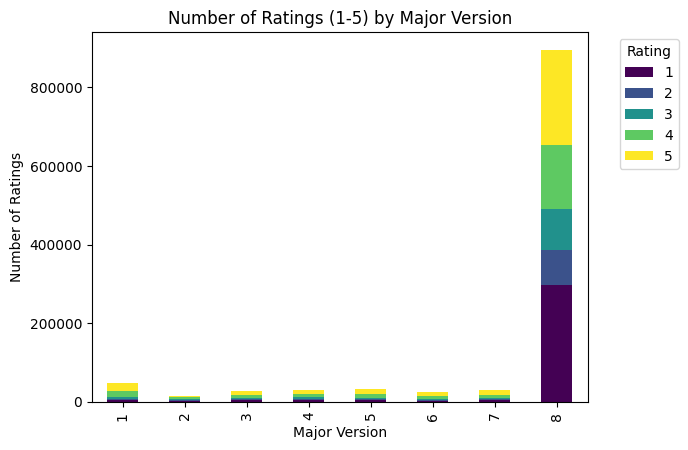

In [37]:
# Group by major version and count the occurrences of each rating
ratings_counts = df.groupby(['major_version', 'review_rating']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ratings_counts.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Number of Ratings (1-5) by Major Version')
plt.xlabel('Major Version')
plt.ylabel('Number of Ratings')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Minor Application Version

Minor version might contains insightful information especially before and after releasing a new version, **lets keep it all for now**. Note that there are some interesting fact that a lot of users feedbacks are using minor between 4 and 8.

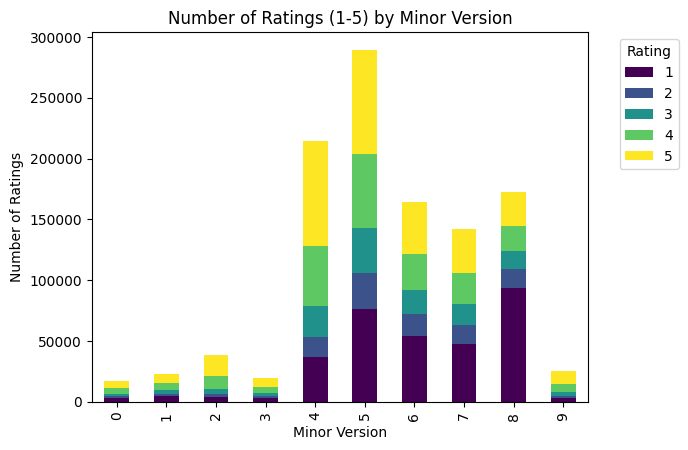

In [38]:
# Group by minor version and count the occurrences of each rating
ratings_counts = df.groupby(['minor_version', 'review_rating']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ratings_counts.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Number of Ratings (1-5) by Minor Version')
plt.xlabel('Minor Version')
plt.ylabel('Number of Ratings')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Patch Application Version

As you can see, there are a lot of patch versions used by our users. Let's see if we can other useful information by combining the Major 8 and Minor between 4-8.

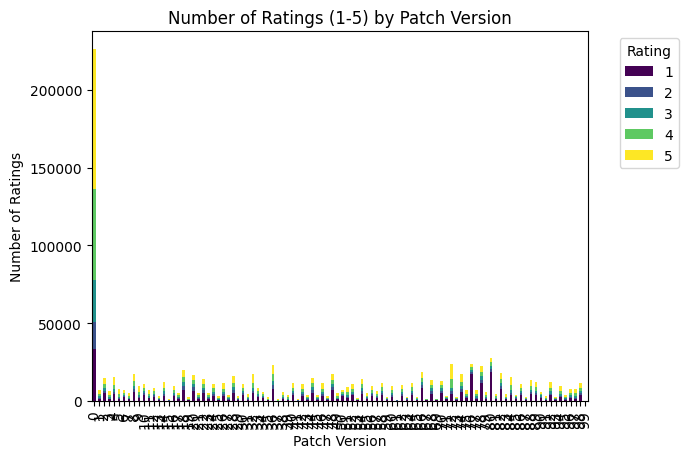

In [39]:
# Group by patch version and count the occurrences of each rating
ratings_counts = df.groupby(['patch_version', 'review_rating']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ratings_counts.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Number of Ratings (1-5) by Patch Version')
plt.xlabel('Patch Version')
plt.ylabel('Number of Ratings')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


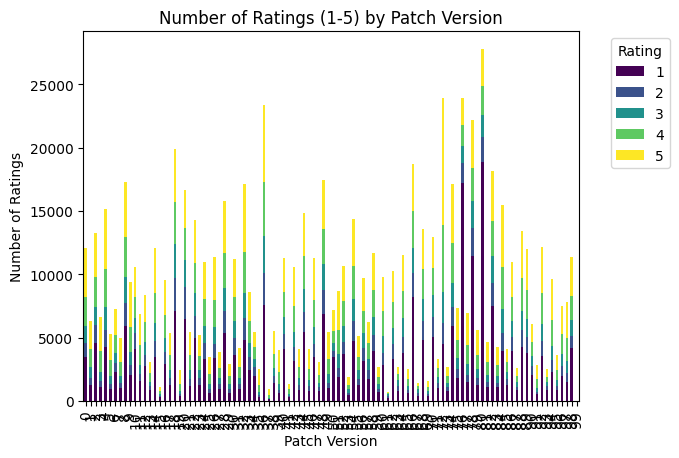

In [40]:
# Filter rows where major_version is 8 and minor_version is between 4 and 8
filtered_df = df[(df['major_version'] == 8) & (df['minor_version'].between(4, 8))]

# Plot the bar chart
# Group by patch version and count the occurrences of each rating
ratings_counts = filtered_df.groupby(['patch_version', 'review_rating']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ratings_counts.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Number of Ratings (1-5) by Patch Version')
plt.xlabel('Patch Version')
plt.ylabel('Number of Ratings')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [43]:
# Find the maen of rating counts from each patch version
mean_rating_count = filtered_df.groupby('patch_version')['review_rating'].count().mean()
print(mean_rating_count)

8871.21


## Filtering Based on Application Version

Once we can find the relation between application version and ratings, we can use it to filter out the data ussing the following rules:
- Major version 8
- Include all minor versions
- Patch Version rating counts > 5000 ("8000" to high and only includes minor of 4)

In [44]:
filtered_df = df[df['major_version'] == 8]
filtered_df = filtered_df.groupby('patch_version').filter(lambda group: group['review_rating'].count() > 5000)

In [45]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805249 entries, 0 to 1105621
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          805249 non-null  int64 
 1   review_id           805249 non-null  object
 2   author_name         805249 non-null  object
 3   review_text         805249 non-null  object
 4   review_rating       805249 non-null  int64 
 5   review_likes        805249 non-null  int64 
 6   author_app_version  805249 non-null  object
 7   sentiment           805249 non-null  object
 8   review_month        805249 non-null  object
 9   major_version       805249 non-null  int64 
 10  minor_version       805249 non-null  int64 
 11  patch_version       805249 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 79.9+ MB


## Filtering Based on Word Counts

Previously, we're using a naive approach to remove reviews that have less than 3 words. Now, let's use a statistical approach and remove rows that have less than the mean of number of rows from all review_text

In [54]:
# Split sentences into words and count the number of words in each row
filtered_df["word_count"] = filtered_df["review_text"].str.split().apply(len)
print(filtered_df["word_count"].agg(["min", "max", "mean"]))

min       4.000000
max     699.000000
mean     24.035963
Name: word_count, dtype: float64


In [55]:
filtered_df = filtered_df[filtered_df["word_count"] >= 24]

In [56]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287373 entries, 1 to 1105621
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          287373 non-null  int64 
 1   review_id           287373 non-null  object
 2   author_name         287373 non-null  object
 3   review_text         287373 non-null  object
 4   review_rating       287373 non-null  int64 
 5   review_likes        287373 non-null  int64 
 6   author_app_version  287373 non-null  object
 7   sentiment           287373 non-null  object
 8   review_month        287373 non-null  object
 9   major_version       287373 non-null  int64 
 10  minor_version       287373 non-null  int64 
 11  patch_version       287373 non-null  int64 
 12  word_count          287373 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 30.7+ MB


## Cleaning Up
We finally reduce the data by **74.0081%** from the filtered data or **91.4914%** from the original data.

In [61]:
# Remove unused informations
filtered_df = filtered_df.drop(["Unnamed: 0", "word_count", "author_name", "author_app_version"], axis=1)
filtered_df.to_csv("../data/spotify_filter_version_ratings_count.csv", index=False)

In [62]:
filtered_df.head()

,review_id,review_text,review_rating,review_likes,sentiment,review_month,major_version,minor_version,patch_version
1,59399276-ddd8-4bbc-aa4a-cd6bcd500e90,i love being able to find the music i like. i ...,5,0,Positive,2020-03,8,5,50
15,17efd6d1-4c4d-4842-bacb-bd4f50f552ce,absolutely wonderful. without premium the ads ...,5,2,Positive,2021-11,8,6,78
23,553ae9ae-4f61-4d33-99bb-a863002e0679,love spotify. i've been a prime member for aro...,5,0,Positive,2017-07,8,4,9
28,6afa5d2b-7516-4b2b-82d0-77782e98c0d4,i loved it and decided to upgrade to premium a...,5,0,Positive,2018-08,8,4,52
33,be5612ee-3f73-4d2b-bfc8-4a8e3fdc8b6d,im really happy you can preview songs before y...,5,0,Positive,2022-06,8,7,40


## Statisctics

### Rating Counts

review_rating
1    120091
4     46168
2     45970
3     45318
5     29826
Name: count, dtype: int64


/var/folders/31/c1jnr3_53792wz4xwx7z_5d40000gp/T/ipykernel_10909/3269227519.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="review_rating", data=filtered_df, palette="viridis")


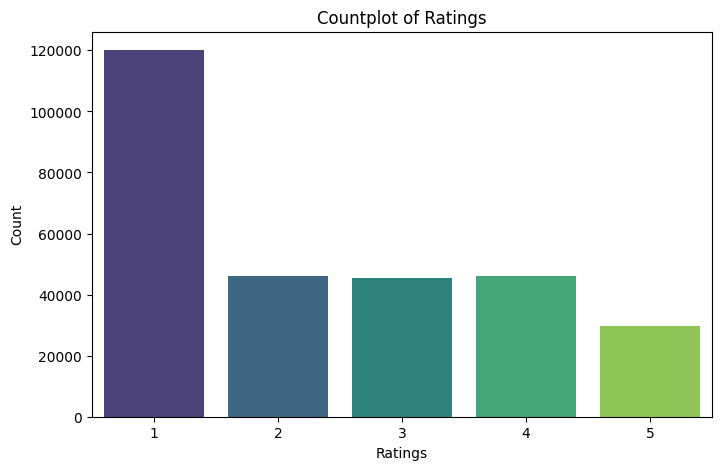

In [59]:
# Plotting counts of ratings for visualization

print(filtered_df["review_rating"].value_counts())  # distribution of ratings

plt.figure(figsize=(8, 5))
sns.countplot(x="review_rating", data=filtered_df, palette="viridis")
plt.title("Countplot of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

### Sentiment Counts

sentiment
Negative    166061
Positive     75994
Neutral      45318
Name: count, dtype: int64


/var/folders/31/c1jnr3_53792wz4xwx7z_5d40000gp/T/ipykernel_10909/753188541.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=filtered_df, palette="viridis")


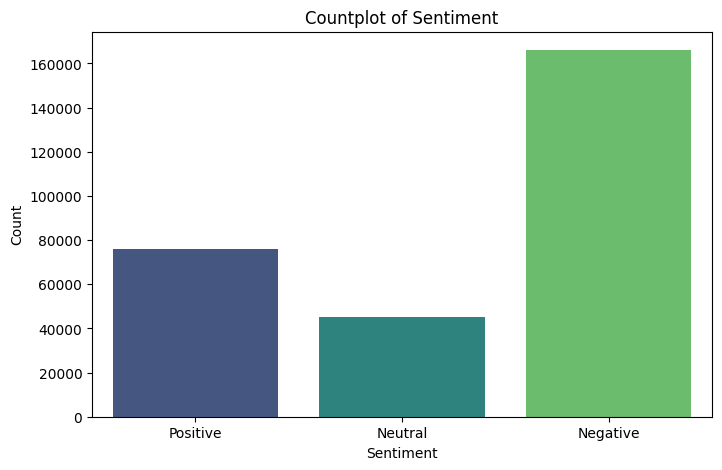

In [60]:
# Plotting counts of sentiment for visualization

print(filtered_df["sentiment"].value_counts())  # distribution of ratings

plt.figure(figsize=(8, 5))
sns.countplot(x="sentiment", data=filtered_df, palette="viridis")
plt.title("Countplot of Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

### Application Version w.r.t Review Dates

    major_version  minor_version
1               8              5
15              8              6
23              8              4
33              8              7
43              8              8


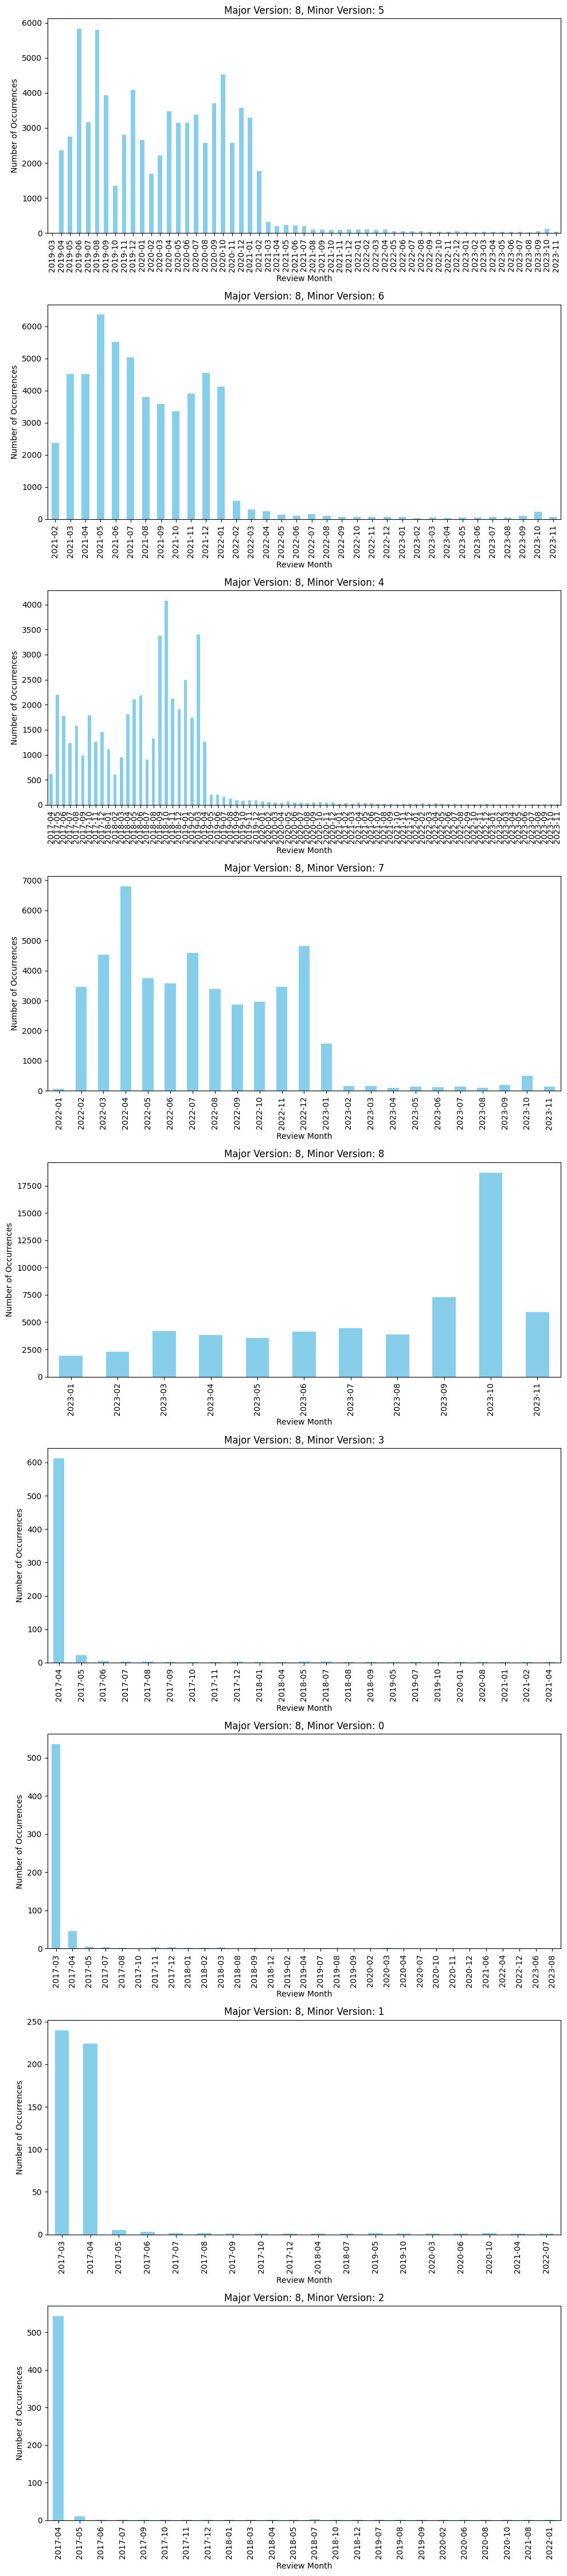

In [57]:
# Create subplots for each combination of major_version and minor_version
unique_combinations = filtered_df[['major_version', 'minor_version']].drop_duplicates()

print(unique_combinations.head())
fig, axes = plt.subplots(len(unique_combinations), 1, figsize=(10, 5 * len(unique_combinations)))

for i, (major, minor) in enumerate(unique_combinations.values):
    temp_df = filtered_df[(filtered_df['major_version'] == major) & (filtered_df['minor_version'] == minor)]
    grouped_df = temp_df.groupby('review_month').size().reset_index(name='count')

    ax = axes[i] if len(unique_combinations) > 1 else axes
    grouped_df.plot(x='review_month', y='count', kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'Major Version: {major}, Minor Version: {minor}')
    ax.set_xlabel('Review Month')
    ax.set_ylabel('Number of Occurrences')
    ax.legend().set_visible(False)

plt.tight_layout()
plt.show()


# Further Analytics

By looking at the rating distribution, there are a lot of data with rating of 1. Let's use the same assumptions that there will be a lot of similar reviews from the rating of 1 and try to downsample the dataset to an exact number to balance the final data.

In [68]:
# Filter rows where 'review_ratings' is not 1 (excluding rows with rating of 1)
rows_without_rating_of_1 = filtered_df[filtered_df['review_rating'] != 1]

# Randomly sample 60,000 rows where 'review_ratings' is 1
sampled_rows = filtered_df[filtered_df['review_rating'] == 1].sample(n=60000, random_state=42)  # Set random_state for reproducibility

# Concatenate the sampled rows with the original rows without rating of 1
balanced_dataset = pd.concat([rows_without_rating_of_1, sampled_rows])


In [69]:
balanced_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227282 entries, 1 to 800893
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   review_id      227282 non-null  object
 1   review_text    227282 non-null  object
 2   review_rating  227282 non-null  int64 
 3   review_likes   227282 non-null  int64 
 4   sentiment      227282 non-null  object
 5   review_month   227282 non-null  object
 6   major_version  227282 non-null  int64 
 7   minor_version  227282 non-null  int64 
 8   patch_version  227282 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 17.3+ MB


In [70]:
print(balanced_dataset["review_rating"].value_counts())  # distribution of ratings

review_rating
1    60000
4    46168
2    45970
3    45318
5    29826
Name: count, dtype: int64


In [71]:
print(balanced_dataset.isnull().sum())  # Null values

review_id        0
review_text      0
review_rating    0
review_likes     0
sentiment        0
review_month     0
major_version    0
minor_version    0
patch_version    0
dtype: int64


In [72]:
balanced_dataset.to_csv("../data/spotify_filter_version_ratings_count_balanced.csv", index=False)

In [73]:
dropped_balanced_dataset = balanced_dataset.drop(["review_id", "review_text"], axis=1)
dropped_balanced_dataset.to_csv("../data/spotify_filter_version_ratings_count_balanced_dropped.csv", index=False)